In [1]:
# Import Packages
import numpy as np
from torch.autograd import Variable
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# Import local model files
from FBRN.myfunc import Physics
from FBRN.myfunc import MyMatmul
from FBRN.main import FBRestNet
from FBRN.model import MyModel
from FBRN.myfunc import Export_hyper

In [3]:
exp1 = FBRestNet(experimentation=Physics(2000,50,1,1), nb_blocks=20, noise = 0.05,folder = './../', im_set="Set1",batch_size=[600,1],lr=1e-3, nb_epochs=[30,1], save=False)

train_set, val_set = exp1.CreateDataSet()


In [4]:
len(val_set.dataset)

200

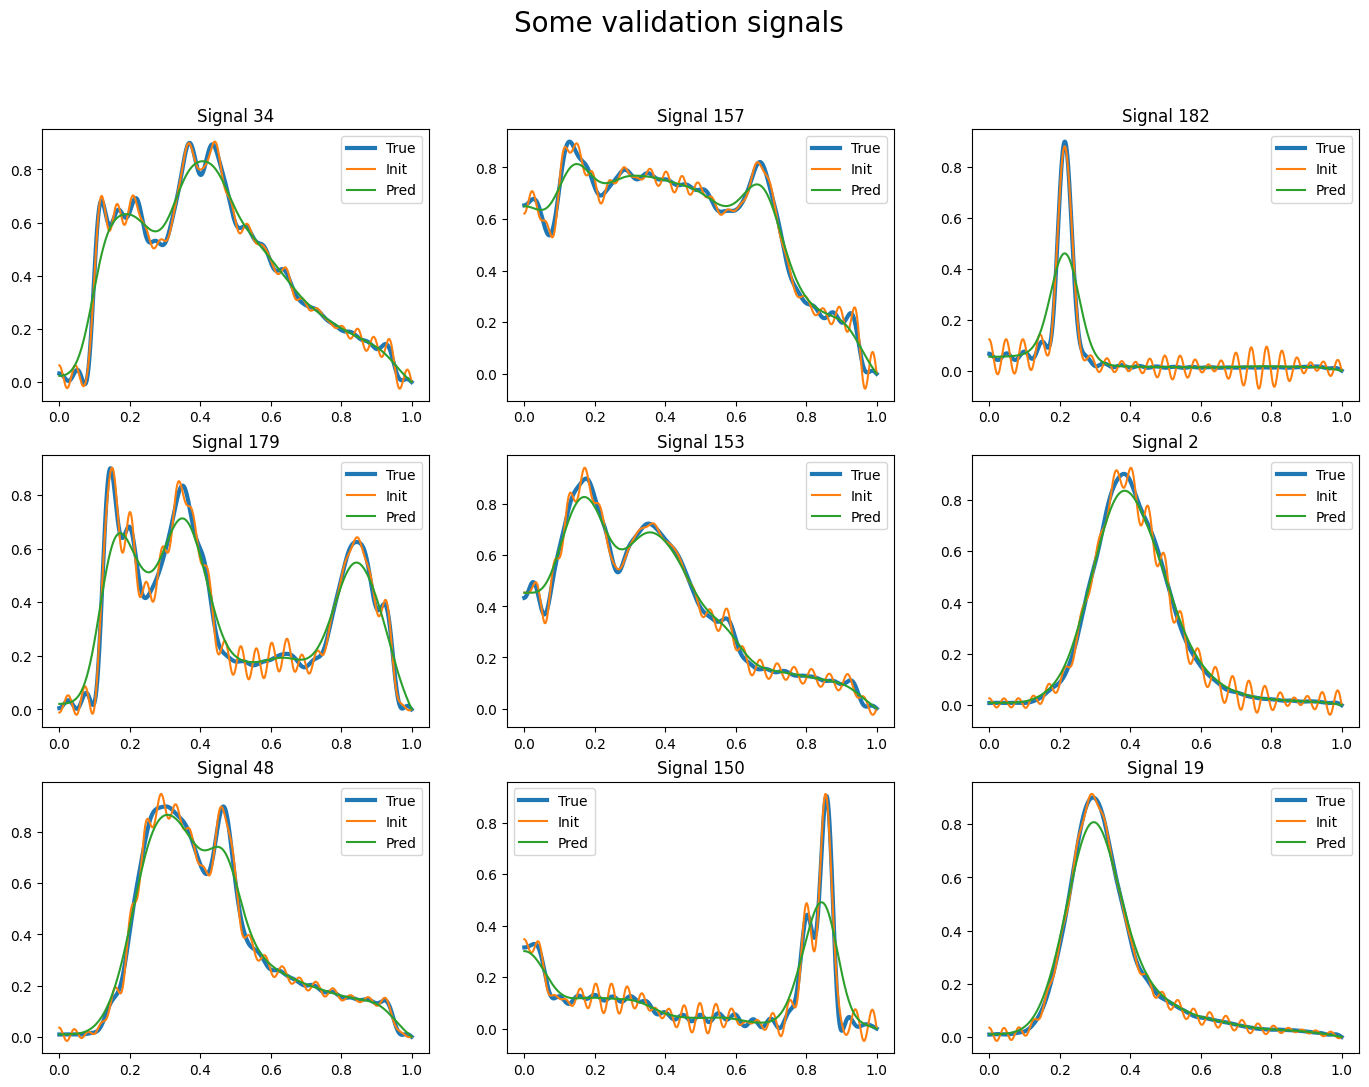

In [5]:
signal_id = 16
with torch.no_grad():
    exp1.model.eval()

    t = np.linspace(0,1,exp1.physics.nx)

    index = np.array(range(0,len(val_set.dataset),1))
    np.random.shuffle(index)

    fig, ax = plt.subplots(3,3,figsize=(17,12))
    fig.suptitle('Some validation signals', fontsize=20)

    for i, signal_id in enumerate(index[:9]):
        [y,x] = val_set.dataset[signal_id:signal_id+1]
        x_true = Variable(x, requires_grad=False)
        x_bias = Variable(y, requires_grad=False)

        x_init   = torch.zeros(x_bias.size())
        inv      = np.diag(exp1.physics.eigm**(2*exp1.physics.a))
        tTTinv   = MyMatmul(inv)
        x_init   = tTTinv(y) # no filtration of high frequences
        x_init   = Variable(x_init,requires_grad=False)

        x_pred = exp1.model(x_init,x_bias)
        
        axis = ax[int(i/3)][i%3]
        axis.plot(t,exp1.physics.BasisChangeInv(x_true.numpy()[0,0]), label='True', linewidth=3)
        axis.plot(t,exp1.physics.BasisChangeInv(x_init.numpy()[0,0]), label='Init')
        axis.plot(t,exp1.physics.BasisChangeInv(x_pred.numpy()[0,0]), label='Pred')
        axis.set_title('Signal {}'.format(signal_id))
        axis.legend()


### How do we get the initial predictions?

$ x_{init} = diag\left[ ( (k+\frac{1}{2}) \pi)^{2a} \right] x_{bias} $

$ x_{bias} = T* ((T x_{true, elt})_{eig} + v_n) $

In [6]:
signal_id = 108

[y,x] = val_set.dataset[signal_id:signal_id+1]
x_true = Variable(x, requires_grad=False)
x_bias = Variable(y, requires_grad=False)

In [7]:
nx             = exp1.physics.nx
m              = exp1.physics.m
a              = exp1.physics.a
noise          = exp1.noise
nsample        = exp1.nsamples
im_set         = exp1.im_set
Teig           = np.diag(exp1.physics.eigm**(-a))

fmax = 4*m//5


#  Etape 3 : obtenir les images bruitees par l' operateur d' ordre a
# transform
x_blurred  = exp1.physics.Compute(exp1.physics.BasisChangeInv(x_true)).squeeze()
# save
###save_blurred.append(x_blurred)
# Etape 4 : noise 
vn          = np.zeros(m)
vn_temp     = np.random.randn(m)*exp1.physics.eigm**(-2*a)
vn[fmax:]   = vn_temp[fmax:]
vn_elt      = exp1.physics.BasisChangeInv(vn)
vn_elt      = vn_elt/np.linalg.norm(vn_elt)
x_blurred_n = x_blurred + exp1.noise*np.linalg.norm(x_blurred)*vn_elt
# save
####save_blurred_n.append(x_blurred_n)
# Etape 5 : bias
x_b       = exp1.physics.ComputeAdjoint(x_blurred.reshape(1,-1))
x_b      += (Teig.dot(vn)).reshape(1,-1) # noise
x_b       = x_b.reshape(1,-1)